# 1-4,时间序列数据建模流程范例

2020年发生的新冠肺炎疫情灾难给各国人民的生活造成了诸多方面的影响。

有的同学是收入上的，有的同学是感情上的，有的同学是心理上的，还有的同学是体重上的。

本文基于中国2020年3月之前的疫情数据，建立时间序列RNN模型，对中国的新冠肺炎疫情结束时间进行预测。

![](./data/疫情前后对比.png)

<br>

<font color="red">
 
公众号 **算法美食屋** 回复关键词：**pytorch**， 获取本项目源码和所用数据集百度云盘下载链接。
    
</font> 


In [1]:
import os
import datetime
import torchkeras

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 
from python_cgtools.utils_date import *
from python_cgtools.utils_torch import *

torch.__version__ =  2.0.1+cu118
torchvision.__version__ =  0.15.2+cu118
pytorch_lightning.__version__ =  2.0.2
torchtext.__version__ =  0.15.2
torchdata.__version__ =  0.6.1
torchmetrics.__version__ =  0.11.4
torchkeras.__version__ =  3.8.2
yaml.__version__ =  6.0
tensorflow sed random seed fail.


In [2]:
start_time = time.time()
print_with_time("start.........")

2023-05-28 21:41:23:start.........


In [3]:
import torch 
import pytorch_lightning
print("torch.__version__ = ", torch.__version__)
print("pytorch_lightning.__version__ = ", pytorch_lightning.__version__) 


torch.__version__ =  2.0.1+cu118
pytorch_lightning.__version__ =  2.0.2


```
torch.__version__ =  1.10.0
pytorch_lightning.__version__ =  1.6.5
```

## 一，准备数据

本文的数据集取自tushare，获取该数据集的方法参考了以下文章。

《https://zhuanlan.zhihu.com/p/109556102》

![](./data/1-4-新增人数.png)


![](./data/1-4-新增人数.png)

In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt


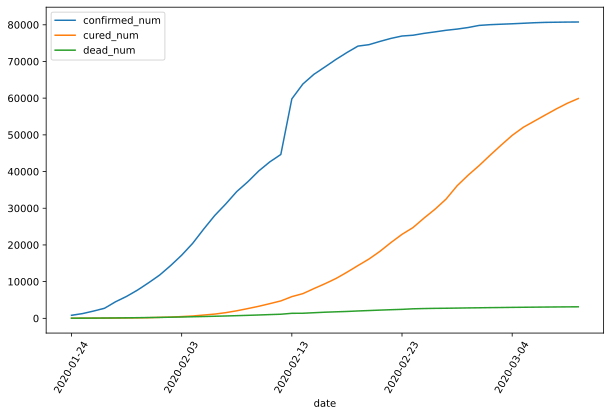

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

df = pd.read_csv("./eat_pytorch_datasets/covid-19.csv",sep = "\t")
df.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60);


In [6]:
df

,date,confirmed_num,cured_num,dead_num
0,2020-01-24,830.0,34.0,25.0
1,2020-01-25,1287.0,38.0,41.0
2,2020-01-26,1975.0,49.0,56.0
3,2020-01-27,2744.0,51.0,80.0
4,2020-01-28,4515.0,60.0,106.0
5,2020-01-29,5974.0,103.0,132.0
6,2020-01-30,7711.0,124.0,170.0
7,2020-01-31,9692.0,171.0,213.0
8,2020-02-01,11791.0,259.0,243.0
9,2020-02-02,14380.0,328.0,304.0


![](./data/1-4-累积曲线.png)

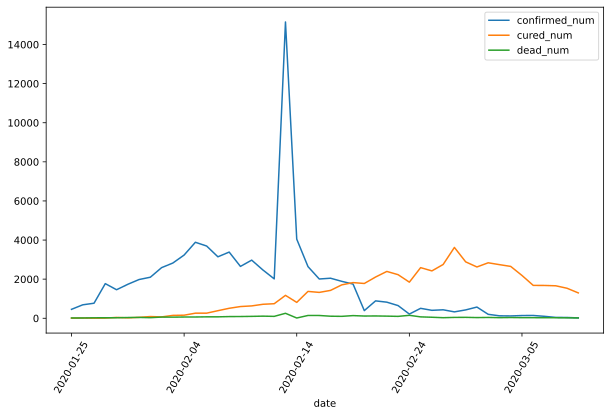

In [7]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")

dfdiff.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date",axis = 1).astype("float32")


![](./data/1-4-新增曲线.png)

In [8]:
dfdiff

,confirmed_num,cured_num,dead_num
0,457.0,4.0,16.0
1,688.0,11.0,15.0
2,769.0,2.0,24.0
3,1771.0,9.0,26.0
4,1459.0,43.0,26.0
5,1737.0,21.0,38.0
6,1981.0,47.0,43.0
7,2099.0,88.0,30.0
8,2589.0,69.0,61.0
9,2825.0,147.0,57.0


![](./data/1-4-dfdiff.png)

下面我们通过继承torch.utils.data.Dataset实现自定义时间序列数据集。

torch.utils.data.Dataset是一个抽象类，用户想要加载自定义的数据只需要继承这个类，并且覆写其中的两个方法即可：

* `__len__`:实现len(dataset)返回整个数据集的大小。
* `__getitem__`:用来获取一些索引的数据，使`dataset[i]`返回数据集中第i个样本。

不覆写这两个方法会直接返回错误。


In [9]:
import torch 
from torch import nn 
from torch.utils.data import Dataset,DataLoader,TensorDataset


#用某日前8天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8

class Covid19Dataset(Dataset):
        
    def __len__(self):
        return len(dfdiff) - WINDOW_SIZE
    
    def __getitem__(self,i):
        x = dfdiff.loc[i:i+WINDOW_SIZE-1,:]
        feature = torch.tensor(x.values)
        y = dfdiff.loc[i+WINDOW_SIZE,:]
        label = torch.tensor(y.values)
        return (feature,label)
    
ds_train = Covid19Dataset()

#数据较小，可以将全部训练数据放入到一个batch中，提升性能
dl_train = DataLoader(ds_train,batch_size = 19, collate_fn=cuda_collate_fn) # 38

#dl_train同时作为验证集
dl_val = dl_train


for features,labels in dl_train:
    print(features,labels)
    # torch.Size([19, 8, 3]) torch.Size([19, 3])
    print(features.shape,labels.shape)
    break

tensor([[[4.5700e+02, 4.0000e+00, 1.6000e+01],
         [6.8800e+02, 1.1000e+01, 1.5000e+01],
         [7.6900e+02, 2.0000e+00, 2.4000e+01],
         [1.7710e+03, 9.0000e+00, 2.6000e+01],
         [1.4590e+03, 4.3000e+01, 2.6000e+01],
         [1.7370e+03, 2.1000e+01, 3.8000e+01],
         [1.9810e+03, 4.7000e+01, 4.3000e+01],
         [2.0990e+03, 8.8000e+01, 3.0000e+01]],

        [[6.8800e+02, 1.1000e+01, 1.5000e+01],
         [7.6900e+02, 2.0000e+00, 2.4000e+01],
         [1.7710e+03, 9.0000e+00, 2.6000e+01],
         [1.4590e+03, 4.3000e+01, 2.6000e+01],
         [1.7370e+03, 2.1000e+01, 3.8000e+01],
         [1.9810e+03, 4.7000e+01, 4.3000e+01],
         [2.0990e+03, 8.8000e+01, 3.0000e+01],
         [2.5890e+03, 6.9000e+01, 6.1000e+01]],

        [[7.6900e+02, 2.0000e+00, 2.4000e+01],
         [1.7710e+03, 9.0000e+00, 2.6000e+01],
         [1.4590e+03, 4.3000e+01, 2.6000e+01],
         [1.7370e+03, 2.1000e+01, 3.8000e+01],
         [1.9810e+03, 4.7000e+01, 4.3000e+01],
         

In [10]:
# 38
len(ds_train)

38

## 二，定义模型

使用Pytorch通常有三种方式构建模型：使用nn.Sequential按层顺序构建模型，继承nn.Module基类构建自定义模型，继承nn.Module基类构建模型并辅助应用模型容器进行封装。

此处选择第二种方式构建模型。



In [11]:
import torch
from torch import nn 
import importlib 
import torchkeras 

class Block(nn.Module):
    def __init__(self):
        super(Block,self).__init__()
    
    def forward(self,x,x_input):
        # 这里加了一些 trick，并不是直接预测输出值，而是预测相比于前一天的增长率
        # 因为输出值可能是个几十、几百的数，相比于网络的初始化参数（输出一般均值在 0 附近），太大了，不容易收敛
        # 而 增长率 一般就是较小的一个数，而且均值也是，同时外加 0 作为保护，使得最终输出一定不会小于零
        x_out = torch.max((1+x)*x_input[:,-1,:],torch.tensor(0.0))
        return x_out
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3层lstm
        self.lstm = nn.LSTM(input_size = 3,hidden_size = 3,num_layers = 5,batch_first = True)
        self.linear = nn.Linear(3,3)
        self.block = Block()
        
    def forward(self,x_input):
        x = self.lstm(x_input)[0][:,-1,:]
        x = self.linear(x)
        y = self.block(x,x_input)
        return y
        
net = Net()
net = net.to(device)
# Net(
#   (lstm): LSTM(3, 3, num_layers=5, batch_first=True)
#   (linear): Linear(in_features=3, out_features=3, bias=True)
#   (block): Block()
# )
print(net)



Net(
  (lstm): LSTM(3, 3, num_layers=5, batch_first=True)
  (linear): Linear(in_features=3, out_features=3, bias=True)
  (block): Block()
)


```
Net(
  (lstm): LSTM(3, 3, num_layers=5, batch_first=True)
  (linear): Linear(in_features=3, out_features=3, bias=True)
  (block): Block()
)
```

In [12]:
# Layer (type)                            Output Shape              Param #
# ==========================================================================
# LSTM-1                                    [-1, 8, 3]                  480
# Linear-2                                     [-1, 3]                   12
# Block-3                                      [-1, 3]                    0
# ==========================================================================
# Total params: 492
# Trainable params: 492
# Non-trainable params: 0
# --------------------------------------------------------------------------
# Input size (MB): 0.000069
# Forward/backward pass size (MB): 0.000229
# Params size (MB): 0.001877
# Estimated Total Size (MB): 0.002174
from torchkeras import summary
summary(net,input_data=features);

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
LSTM-1                                    [-1, 8, 3]                  480
Linear-2                                     [-1, 3]                   12
Block-3                                      [-1, 3]                    0
Total params: 492
Trainable params: 492
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000069
Forward/backward pass size (MB): 0.000229
Params size (MB): 0.001877
Estimated Total Size (MB): 0.002174
--------------------------------------------------------------------------


```
--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
==========================================================================
LSTM-1                                    [-1, 8, 3]                  480
Linear-2                                     [-1, 3]                   12
Block-3                                      [-1, 3]                    0
==========================================================================
Total params: 492
Trainable params: 492
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000069
Forward/backward pass size (MB): 0.000229
Params size (MB): 0.001877
Estimated Total Size (MB): 0.002174
--------------------------------------------------------------------------

```

### 三，训练模型

训练Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。

此处介绍一种引进pytorch_lightning库实现的类形式的训练循环。

该训练循环的代码也是torchkeras库中LightModel类的核心代码。

torchkeras详情:  https://github.com/lyhue1991/torchkeras 

注：循环神经网络调试较为困难，需要设置多个不同的学习率多次尝试，以取得较好的效果。


In [13]:
# 从一个 epoch 的各个 step 的输出 list 中获取 summary
# 针对 count 的加权平均
def get_count_weighted_summary_from_output_dict_list(_list, _pre=None):
    metric_list_dict = defaultdict(list)
    for _dict in _list:
        assert "count" in _dict
        for metric_name in _dict:
            metric_list_dict[metric_name].append(_dict[metric_name])

    summary_metric_dict = dict()
    summary_metric_dict["count"] = sum(metric_list_dict["count"])
    for metric_name in metric_list_dict:
        if metric_name != "count":
            summary_metric_dict[metric_name] = sum(metric_list_dict[metric_name]) / summary_metric_dict["count"]
    return add_pre_to_dict_key(summary_metric_dict, _pre)


# 在一个 dict 的每个 key 前面增加前缀
def add_pre_to_dict_key(_dict, _pre=None):
    if _pre is None:
        return _dict
    new_dict = dict()
    for key, value in _dict.items():
        new_dict[F"{_pre}{key}"] = value
    return new_dict

In [14]:
import torch 
from torch import nn 
import pytorch_lightning as pl
import datetime
import sys 
import numpy as np
import pandas as pd 
from copy import deepcopy


class LightModel(pl.LightningModule):
    def __init__(self,net,loss_fn,metrics_dict=None,optimizer=None,lr_scheduler=None):
        super().__init__()
        self.net = net
        self.history = {}
        self.train_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []
        
        self.train_metrics = nn.ModuleDict(metrics_dict)
        self.val_metrics = deepcopy(self.train_metrics)
        self.test_metrics = deepcopy(self.train_metrics)
        
        self.loss_fn = loss_fn
        self.optimizer = optimizer if optimizer is not None else torch.optim.Adam(self.parameters(), lr=1e-2)
        self.lr_scheduler = lr_scheduler 
        
        # D:\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:197: UserWarning: Attribute 'net' is an instance of `nn.Module` 
        # and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
        # 理论上，net 的初始权重没有必要保存在 超参数中
        for p in ["net","loss_fn","metrics_dict","optimizer","lr_scheduler"]:
#             if p == "net":
#                 continue
            self.save_hyperparameters(p)
        
    def forward(self,x):
        if self.net:
            return self.net.forward(x)
        else:
            raise NotImplementedError
            
    def _get_metrics_step_outputs(self,stage):
        assert stage in ["train", "val", "test"]
        metrics = self.train_metrics if stage=="train" else (self.val_metrics if stage=="val" else self.test_metrics)
        step_outputs = self.train_step_outputs if stage=="train" else (self.validation_step_outputs if stage=="val" else self.test_step_outputs)
        
        return metrics, step_outputs
    
    def _reset_metrics_step_outputs(self,stage):
        assert stage in ["train", "val", "test"]
        metrics, step_outputs = self._get_metrics_step_outputs(stage)
        for name in metrics:
            metrics[name].reset()
        step_outputs.clear()
            
    def _shared_step(self,batch,batch_idx, stage):
        assert stage in ["train", "val", "test"]
        x, y = batch
        count = len(y)
        preds = self(x)
        loss = self.loss_fn(preds,y)
        metrics, step_outputs = self._get_metrics_step_outputs(stage)
        step_outputs_dict = {"loss": loss.item(), "count": count}
        for name in metrics:
            step_outputs_dict[name] = metrics[name](preds, y).item()
            if stage=="train":
                self.log(name,step_outputs_dict[name],prog_bar=True)
        step_outputs.append(step_outputs_dict)
        # 只返回 loss 即可
        return {'loss': loss}
    
    def configure_optimizers(self):
        if self.lr_scheduler is None:
            return self.optimizer
        return {"optimizer":self.optimizer,"lr_scheduler":self.lr_scheduler}
    
    def training_step(self, batch, batch_idx):
        return self._shared_step(batch,batch_idx, "train")
    
    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch,batch_idx, "val")
    
    def test_step(self, batch, batch_idx):
        return self._shared_step(batch,batch_idx, "test")
    
    def predict_step(self, batch, batch_idx):
        if isinstance(batch,(list, tuple)) and len(batch)==2:
            return self(batch[0])
        else:
            return self(batch)
        
#     def shared_step_end(self,outputs,stage):
#         metrics = self.train_metrics if stage=="train" else (
#             self.val_metrics if stage=="val" else self.test_metrics)
#         for name in metrics:
#             step_metric = metrics[name](outputs['preds'], outputs['y']).item()
#             if stage=="train":
#                 self.log(name,step_metric,prog_bar=True)
#         return outputs["loss"].mean()
        
#     def training_step_end(self, outputs):
#         return {'loss':self.shared_step_end(outputs,"train")}
            
#     def validation_step_end(self, outputs):
#         return {'val_loss':self.shared_step_end(outputs,"val")}
            
#     def test_step_end(self, outputs):
#         return {'test_loss':self.shared_step_end(outputs,"test")}

            
    def shared_epoch_end(self,stage="train"):
        assert stage in ["train", "val", "test"]
        metrics, step_outputs = self._get_metrics_step_outputs(stage)
        dic = get_count_weighted_summary_from_output_dict_list(step_outputs, stage + "_")
        epoch = self.trainer.current_epoch
        dic["epoch"] = epoch
        
        if stage!='test':
            self.history[epoch] = dict(self.history.get(epoch,{}),**dic)
            
        self._reset_metrics_step_outputs(stage)
        return dic
        
#         metrics = self.train_metrics if stage=="train" else (
#             self.val_metrics if stage=="val" else self.test_metrics)
        
#         epoch = self.trainer.current_epoch
#         stage_loss = torch.mean(torch.tensor([t[(stage+"_loss").replace('train_','')] for t in outputs])).item()
#         dic = {"epoch":epoch,stage+"_loss":stage_loss}
        
#         for name in metrics:
#             epoch_metric = metrics[name].compute().item() 
#             metrics[name].reset()
#             dic[stage+"_"+name] = epoch_metric 
#         if stage!='test':
#             self.history[epoch] = dict(self.history.get(epoch,{}),**dic)    
#         return dic 
    
    def on_train_epoch_end(self):
        dic = self.shared_epoch_end("train")
        self.print(dic)
        dic.pop("epoch",None)
        self.log_dict(dic, logger=True)

    def on_validation_epoch_end(self):
        dic = self.shared_epoch_end("val")
        self.print_bar()
        self.print(dic)
        dic.pop("epoch",None)
        self.log_dict(dic, logger=True)
        
        # log when reach best score
        # pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object
        ckpt_cb = self.trainer.checkpoint_callback
        print(ckpt_cb)
        monitor = ckpt_cb.monitor 
        mode = ckpt_cb.mode 
        arr_scores = self.get_history()[monitor]
        best_score_idx = np.argmax(arr_scores) if mode=="max" else np.argmin(arr_scores)
        if best_score_idx==len(arr_scores)-1:   
            self.print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor,
                 arr_scores[best_score_idx]),file=sys.stderr)
            torch.save(self.net.state_dict(), "./data/1_4_net_parameter.pt")

    def on_test_epoch_end(self):
        dic = self.shared_epoch_end("test")
        dic.pop("epoch",None)
        self.print(dic)
        self.log_dict(dic, logger=True)
        
    def get_history(self):
        return pd.DataFrame(self.history.values()) 
    
    def print_bar(self): 
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        self.print("\n"+"="*80 + "%s"%nowtime)
        

In [15]:
from torchmetrics.regression import MeanAbsolutePercentageError

# 因为有三个输出，而且量级有差异，因此用了比值而不是 mse
def mspe(y_pred,y_true):
    err_percent = (y_true - y_pred)**2/(torch.max(y_true**2,torch.tensor(1e-7)))
    return torch.mean(err_percent)


net = Net()
net = net.to(device)
loss_fn = mspe
metric_dict = {"mape":MeanAbsolutePercentageError()}

optimizer = torch.optim.Adam(net.parameters(), lr=0.03)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.0001)

model = LightModel(net,
       loss_fn = loss_fn,
       metrics_dict= metric_dict,
       optimizer = optimizer,
       lr_scheduler = lr_scheduler)       


D:\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:197: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(


In [16]:
# Parameter containing:
# tensor([[ 0.4569,  0.3446,  0.2417],
#         [ 0.3981, -0.3061,  0.5637],
#         [ 0.2328, -0.2315, -0.2579]], device='cuda:0', requires_grad=True)
net.linear.weight

Parameter containing:
tensor([[ 0.4569,  0.3446,  0.2417],
        [ 0.3981, -0.3061,  0.5637],
        [ 0.2328, -0.2315, -0.2579]], device='cuda:0', requires_grad=True)

In [17]:
import pytorch_lightning as pl     

#1，设置回调函数

model_ckpt = pl.callbacks.ModelCheckpoint(
    monitor='val_mape',
    save_top_k=1,
    mode='min'
)

early_stopping = pl.callbacks.EarlyStopping(monitor = 'val_mape',
                           patience=3,
                           mode = 'min'
                          )

#2，设置训练参数
# gpus=0 则使用cpu训练，gpus=1则使用1个gpu训练，gpus=2则使用2个gpu训练，gpus=-1则使用所有gpu训练，
# gpus=[0,1]则指定使用0号和1号gpu训练， gpus="0,1,2,3"则使用0,1,2,3号gpu训练
# tpus=1 则使用1个tpu训练
trainer = pl.Trainer(logger=True,
                     min_epochs=3,max_epochs=30,
#                      accelerator="cpu",
#                      accelerator="gpu",
                     accelerator = "gpu" if torch.cuda.is_available() else "cpu",
                     devices = 1 if torch.cuda.is_available() else "auto",
                     callbacks = [model_ckpt,early_stopping],
                     enable_progress_bar = True,
                     log_every_n_steps=1) 


##3，启动训练循环
trainer.fit(model,dl_train,dl_val)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
D:\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | net           | Net        | 492   
1 | train_metrics | ModuleDict | 0     
2 | val_metrics   | ModuleDict | 0     
3 | test_metrics  | ModuleDict | 0     
---------

Sanity Checking: 0it [00:00, ?it/s]

D:\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
D:\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:212: UserWarning: You called `self.log('val_count', ...)` in your `on_validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
<<<<<< reach best val_mape : 0.045272693822258396 >>>>>>
D:\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the


================================================================================2023-05-28 21:41:26
{'val_count': 38, 'val_loss': 0.22751240353835256, 'val_mape': 0.045272693822258396, 'epoch': 0}


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


================================================================================2023-05-28 21:41:27
{'val_count': 38, 'val_loss': 0.17369403337177478, 'val_mape': 0.041159137299186306, 'epoch': 0}
{'train_count': 38, 'train_loss': 0.22566827661112734, 'train_mape': 0.0442865694824018, 'epoch': 0}


<<<<<< reach best val_mape : 0.041159137299186306 >>>>>>
D:\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:212: UserWarning: You called `self.log('train_count', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]


================================================================================2023-05-28 21:41:27
{'val_count': 38, 'val_loss': 0.13608747407009728, 'val_mape': 0.03792219256099902, 'epoch': 1}
{'train_count': 38, 'train_loss': 0.17173013561650327, 'train_mape': 0.04040999945841337, 'epoch': 1}


<<<<<< reach best val_mape : 0.03792219256099902 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-05-28 21:41:28
{'val_count': 38, 'val_loss': 0.10368115807834424, 'val_mape': 0.035300069733669885, 'epoch': 2}
{'train_count': 38, 'train_loss': 0.134355880712208, 'train_mape': 0.03750401892160114, 'epoch': 2}


<<<<<< reach best val_mape : 0.035300069733669885 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-05-28 21:41:28
{'val_count': 38, 'val_loss': 0.0755144969413155, 'val_mape': 0.03272422520737899, 'epoch': 3}
{'train_count': 38, 'train_loss': 0.10222948381775304, 'train_mape': 0.03488841652870178, 'epoch': 3}


<<<<<< reach best val_mape : 0.03272422520737899 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-05-28 21:41:29
{'val_count': 38, 'val_loss': 0.05279974560988577, 'val_mape': 0.030424342343681736, 'epoch': 4}
{'train_count': 38, 'train_loss': 0.07437264762426678, 'train_mape': 0.032491825128856455, 'epoch': 4}


<<<<<< reach best val_mape : 0.030424342343681736 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-05-28 21:41:29
{'val_count': 38, 'val_loss': 0.037419872064339485, 'val_mape': 0.028701562630502803, 'epoch': 5}
{'train_count': 38, 'train_loss': 0.05203850645768015, 'train_mape': 0.030300498008728027, 'epoch': 5}


<<<<<< reach best val_mape : 0.028701562630502803 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-05-28 21:41:30
{'val_count': 38, 'val_loss': 0.02992209713709982, 'val_mape': 0.02816439772907056, 'epoch': 6}
{'train_count': 38, 'train_loss': 0.03707505762577057, 'train_mape': 0.028655742344103362, 'epoch': 6}


<<<<<< reach best val_mape : 0.02816439772907056 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-05-28 21:41:30
{'val_count': 38, 'val_loss': 0.02797512710094452, 'val_mape': 0.028848390830190557, 'epoch': 7}
{'train_count': 38, 'train_loss': 0.02985664261014838, 'train_mape': 0.028369031454387465, 'epoch': 7}


Validation: 0it [00:00, ?it/s]


================================================================================2023-05-28 21:41:31
{'val_count': 38, 'val_loss': 0.025957493405593068, 'val_mape': 0.029308228116286427, 'epoch': 8}
{'train_count': 38, 'train_loss': 0.027759267311347157, 'train_mape': 0.028881455722608064, 'epoch': 8}


Validation: 0it [00:00, ?it/s]


================================================================================2023-05-28 21:41:31
{'val_count': 38, 'val_loss': 0.024333879351615906, 'val_mape': 0.029564299081501207, 'epoch': 9}
{'train_count': 38, 'train_loss': 0.025651818827578898, 'train_mape': 0.02927755211528979, 'epoch': 9}


In [18]:
# val_count	val_loss	val_mape	epoch	train_count	train_loss	train_mape
# 0	38	0.173694	0.041159	0	38	0.225668	0.044287
# 1	38	0.136087	0.037922	1	38	0.171730	0.040410
# 2	38	0.103681	0.035300	2	38	0.134356	0.037504
# 3	38	0.075514	0.032724	3	38	0.102229	0.034888
# 4	38	0.052800	0.030424	4	38	0.074373	0.032492
# 5	38	0.037420	0.028702	5	38	0.052038	0.030300
# 6	38	0.029922	0.028164	6	38	0.037075	0.028656
# 7	38	0.027975	0.028848	7	38	0.029857	0.028369
# 8	38	0.025957	0.029308	8	38	0.027759	0.028881
# 9	38	0.024334	0.029564	9	38	0.025652	0.029278
dfhistory = model.get_history() 
dfhistory 

,val_count,val_loss,val_mape,epoch,train_count,train_loss,train_mape
0,38,0.173694,0.041159,0,38,0.225668,0.044287
1,38,0.136087,0.037922,1,38,0.171730,0.040410
2,38,0.103681,0.035300,2,38,0.134356,0.037504
3,38,0.075514,0.032724,3,38,0.102229,0.034888
4,38,0.052800,0.030424,4,38,0.074373,0.032492
5,38,0.037420,0.028702,5,38,0.052039,0.030300
6,38,0.029922,0.028164,6,38,0.037075,0.028656
7,38,0.027975,0.028848,7,38,0.029857,0.028369
8,38,0.025957,0.029308,8,38,0.027759,0.028881
9,38,0.024334,0.029564,9,38,0.025652,0.029278


```
epoch	val_loss	val_mape	train_loss	train_mape
0	0	5.974455	0.661542	6.936645	0.737031
1	1	5.086240	0.590996	5.974455	0.661542
2	2	4.237600	0.524000	5.086240	0.590996
3	3	3.408828	0.463179	4.237600	0.524000
4	4	2.614143	0.422679	3.408828	0.463179
5	5	1.896354	0.413116	2.614143	0.422679
6	6	1.304007	0.437700	1.896354	0.413116
7	7	0.866170	0.474878	1.304007	0.437700
8	8	0.585183	0.517995	0.866170	0.474878
	
```

### 四，评估模型

评估模型一般要设置验证集或者测试集，由于此例数据较少，我们仅仅可视化损失函数在训练集上的迭代情况。

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory["train_"+metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


In [20]:
#使用最佳保存点进行评估
# [{'test_count': 38.0,
#   'test_loss': 0.02992209792137146,
#   'test_mape': 0.028164399787783623}]
trainer.test(ckpt_path='best', dataloaders=dl_val,verbose = False)


Restoring states from the checkpoint path at D:\PycharmProjects\eat_pytorch_in_20_days\lightning_logs\version_47\checkpoints\epoch=6-step=14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at D:\PycharmProjects\eat_pytorch_in_20_days\lightning_logs\version_47\checkpoints\epoch=6-step=14.ckpt
D:\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

D:\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:212: UserWarning: You called `self.log('test_count', ...)` in your `on_test_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


{'test_count': 38, 'test_loss': 0.02992209713709982, 'test_mape': 0.02816439772907056}


[{'test_count': 38.0,
  'test_loss': 0.02992209792137146,
  'test_mape': 0.028164397925138474}]

```
{'test_loss': 1.8963541984558105, 'test_mape': 0.4131162464618683}
```

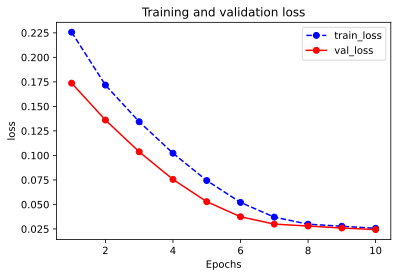

In [21]:
plot_metric(dfhistory,"loss")

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h48rhp9jpqj20ej0acwer.jpg)

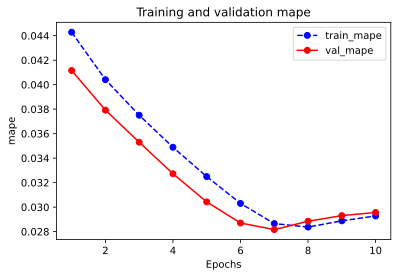

In [22]:
plot_metric(dfhistory,"mape")

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h48rj15ctvj20f70ag3yv.jpg)

### 五，使用模型

此处我们使用模型预测疫情结束时间，即 新增确诊病例为0 的时间。

In [23]:
#使用dfresult记录现有数据以及此后预测的疫情数据
# confirmed_num	cured_num	dead_num
# 41	143.0	1681.0	30.0
# 42	99.0	1678.0	28.0
# 43	44.0	1661.0	27.0
# 44	40.0	1535.0	22.0
# 45	19.0	1297.0	17.0
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


![](./data/1-4-日期3月10.png)

In [24]:
#预测此后1000天的新增走势,将其结果添加到dfresult中
# 注意，输入是相邻两天的 diff
for i in range(1000):
    # 注意，这里用 -38 也能跑通，因为 lstm 理论上是不在乎输入的个数的，但因为训练的时候都是用的 8，因此这里最好也用 8
    arr_input = torch.unsqueeze(torch.from_numpy(dfresult.values[-8:,:]),axis=0)
    arr_predict = model.forward(arr_input)
    # torch.Size([1, 8, 3]) # torch.Size([1, 38, 3])
    # torch.Size([1, 3])
    if i == 0:
        print(arr_input.shape)
        print(arr_predict.shape)

    dfpredict = pd.DataFrame(torch.floor(arr_predict).data.numpy(),
                columns = dfresult.columns)
    dfresult = pd.concat([dfresult,dfpredict],ignore_index=True)

torch.Size([1, 8, 3])
torch.Size([1, 3])


In [25]:
# 1046 rows × 3 columns
# confirmed_num	cured_num	dead_num
# 41	143.0	1681.0	30.0
# 42	99.0	1678.0	28.0
# 43	44.0	1661.0	27.0
# 44	40.0	1535.0	22.0
# 45	19.0	1297.0	17.0
# 46	18.0	1159.0	1.0
# 47	17.0	1035.0	0.0
# 48	16.0	925.0	0.0
# 49	15.0	826.0	0.0
# 50	14.0	738.0	0.0
dfresult.loc[41:50]

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0
46,18.0,1169.0,1.0
47,17.0,1054.0,0.0
48,16.0,950.0,0.0
49,15.0,856.0,0.0
50,14.0,772.0,0.0


In [26]:
dfresult.query("confirmed_num==0").head()
# confirmed_num	cured_num	dead_num
# 64	0.0	179.0	0.0
# 65	0.0	161.0	0.0
# 66	0.0	145.0	0.0
# 67	0.0	130.0	0.0
# 68	0.0	117.0	0.0
# 第50天开始新增确诊降为0，第45天对应3月10日，也就是5天后，即预计3月15日新增确诊降为0
# 注：该预测偏乐观

,confirmed_num,cured_num,dead_num
64,0.0,179.0,0.0
65,0.0,161.0,0.0
66,0.0,145.0,0.0
67,0.0,130.0,0.0
68,0.0,117.0,0.0


![](./data/1-4-torch预测确诊.png)

In [27]:
# confirmed_num	cured_num	dead_num
# 98	0.0	0.0	0.0
# 99	0.0	0.0	0.0
# 100	0.0	0.0	0.0
# 101	0.0	0.0	0.0
# 102	0.0	0.0	0.0
dfresult.query("cured_num==0").head()

# 第132天开始新增治愈降为0，第45天对应3月10日，也就是大概3个月后，即6月10日左右全部治愈。
# 注: 该预测偏悲观，并且存在问题，如果将每天新增治愈人数加起来，将超过累计确诊人数。

,confirmed_num,cured_num,dead_num
98,0.0,0.0,0.0
99,0.0,0.0,0.0
100,0.0,0.0,0.0
101,0.0,0.0,0.0
102,0.0,0.0,0.0


![](./data/1-4-torch预测治愈.png)

### 六，保存模型

模型保存在了trainer.checkpoint_callback.best_model_path路径。


In [28]:
net.linear.weight

Parameter containing:
tensor([[ 0.1889,  0.0908, -0.1807],
        [ 0.1233, -0.5486,  0.1808],
        [ 0.0302, -0.3468, -0.5542]], requires_grad=True)

In [29]:
# D:\PycharmProjects\eat_pytorch_in_20_days\lightning_logs\version_27\checkpoints\epoch=6-step=14.ckpt
# tensor(0.0282, device='cuda:0')
print(trainer.checkpoint_callback.best_model_path)
print(trainer.checkpoint_callback.best_model_score)

D:\PycharmProjects\eat_pytorch_in_20_days\lightning_logs\version_47\checkpoints\epoch=6-step=14.ckpt
tensor(0.0282, device='cuda:0')


In [30]:
# pytorch_lightning不仅保留了模型参数，还保存了模型结构，可以用LightModel重新加载
# D:\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:197: UserWarning: Attribute 'net' is an instance of `nn.Module` 
# and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
model_loaded = LightModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

D:\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:197: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(


In [31]:
# 可以手动进行 load
net_loaded = Net()
net_loaded = net_loaded.to(device)
net_loaded.load_state_dict(torch.load("./data/1_4_net_parameter.pt"))

<All keys matched successfully>

In [32]:
# 经过训练之后，net 好像会从 gpu 回到 cpu，不确定原因
net.linear.weight.device

device(type='cpu')

In [33]:
# model_loaded 会根据 Train 的 accelerator 变化
model_loaded.net.linear.weight.device

device(type='cuda', index=0)

In [34]:
# 可以手动进行 load_state_dict load
# 可以直接从 ligntning 的 checkpoint 进行load
# 都可以获得准确的模型权重
assert (net_loaded.linear.weight == net.linear.weight.to(device)).all()
# model_loaded 会根据 Train 的 accelerator 变化
assert (model_loaded.net.linear.weight == net.linear.weight.to(device)).all()

In [35]:
# 不知道什么原因，不能调用 predict_step 方法
# trainer.predict(model_loaded,dataloaders=dl_val)
for batch in dl_val:
    print(model_loaded.predict_step(batch, None).detach())

tensor([[2.0819e+03, 7.9330e+01, 3.2589e+00],
        [2.5679e+03, 6.2202e+01, 6.6265e+00],
        [2.8019e+03, 1.3252e+02, 6.1920e+00],
        [3.2066e+03, 1.4153e+02, 6.9524e+00],
        [3.8543e+03, 2.3438e+02, 7.0610e+00],
        [3.6639e+03, 2.3529e+02, 7.9301e+00],
        [3.1173e+03, 3.4887e+02, 7.9301e+00],
        [3.3574e+03, 4.5975e+02, 9.3423e+00],
        [2.6304e+03, 5.3998e+02, 9.6679e+00],
        [2.9487e+03, 5.6973e+02, 1.0537e+01],
        [2.4469e+03, 6.4454e+02, 1.1731e+01],
        [1.9986e+03, 6.7068e+02, 1.0537e+01],
        [1.5027e+04, 1.0556e+03, 2.7595e+01],
        [4.0140e+03, 7.3200e+02, 1.4126e+00],
        [2.6194e+03, 1.2378e+03, 1.5544e+01],
        [1.9916e+03, 1.1927e+03, 1.5439e+01],
        [2.0314e+03, 1.2844e+03, 1.1414e+01],
        [1.8727e+03, 1.5392e+03, 1.0655e+01],
        [1.7349e+03, 1.6436e+03, 1.4800e+01]], device='cuda:0')
tensor([[3.8785e+02, 1.6032e+03, 1.2429e+01],
        [8.8185e+02, 1.9013e+03, 1.2914e+01],
        [8.1637e

```
[tensor([[1.4974e+03, 8.5825e+01, 2.3000e+01],
         [1.8469e+03, 6.7295e+01, 4.6768e+01],
         [2.0153e+03, 1.4337e+02, 4.3701e+01],
         [2.3063e+03, 1.5312e+02, 4.9068e+01],
         [2.7721e+03, 2.5358e+02, 4.9834e+01],
         [2.6352e+03, 2.5455e+02, 5.5968e+01],
         [2.2421e+03, 3.7744e+02, 5.5968e+01],
         [2.4147e+03, 4.9740e+02, 6.5935e+01],
         [1.8918e+03, 5.8420e+02, 6.8235e+01],
         [2.1208e+03, 6.1638e+02, 7.4368e+01],
         [1.7599e+03, 6.9733e+02, 8.2802e+01],
         [1.4374e+03, 7.2561e+02, 7.4368e+01],
         [1.0808e+04, 1.1421e+03, 1.9474e+02],
         [2.8870e+03, 7.9193e+02, 9.9669e+00],
         [1.8840e+03, 1.3391e+03, 1.0964e+02],
         [1.4324e+03, 1.2903e+03, 1.0887e+02],
         [1.4610e+03, 1.3898e+03, 8.0502e+01],
         [1.3468e+03, 1.6658e+03, 7.5135e+01],
         [1.2477e+03, 1.7789e+03, 1.0427e+02],
         [2.7895e+02, 1.7353e+03, 8.7424e+01],
         [6.3425e+02, 2.0573e+03, 9.0511e+01],
         [5.8716e+02, 2.3365e+03, 8.3624e+01],
         [4.6230e+02, 2.1747e+03, 7.4431e+01],
         [1.5267e+02, 1.8011e+03, 1.1512e+02],
         [3.6241e+02, 2.5261e+03, 5.4495e+01],
         [2.8963e+02, 2.3633e+03, 3.9916e+01],
         [3.0889e+02, 2.6834e+03, 2.2262e+01],
         [2.3327e+02, 3.5342e+03, 3.3777e+01],
         [3.0461e+02, 2.8151e+03, 3.6080e+01],
         [4.0876e+02, 2.5594e+03, 2.6868e+01],
         [1.4410e+02, 2.7683e+03, 3.2242e+01],
         [8.9172e+01, 2.6756e+03, 2.3798e+01],
         [8.4892e+01, 2.5877e+03, 2.9171e+01],
         [9.9159e+01, 2.1360e+03, 2.3798e+01],
         [1.0201e+02, 1.6403e+03, 2.3030e+01],
         [7.0624e+01, 1.6373e+03, 2.1495e+01],
         [3.1389e+01, 1.6208e+03, 2.0727e+01],
         [2.8535e+01, 1.4978e+03, 1.6889e+01]])]
```

In [36]:
# cuda:0
# cpu，这个不太理解为什么是 cpu
for (batch, check_predicts) in zip(dl_val, trainer.predict(model,dataloaders=dl_val)):
    print(model_loaded.predict_step(batch, None).device)
    print(check_predicts.device)
    assert (model_loaded.predict_step(batch, None).detach() == check_predicts.to(device).detach()).all()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
D:\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

cuda:0
cpu
cuda:0
cpu


In [37]:
# cpu: 2023-05-28 21:11:09:spent 10.051 秒
# gpu: 2023-05-28 21:21:44:spent 10.925 秒
end_time = time.time()
print_with_time("spent {}".format(get_time_interval_str(end_time - start_time)))

2023-05-28 21:41:34:spent 10.893 秒


**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)